In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from osgeo import gdal

In [3]:
import numpy as np

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, CenterCrop, Pad
from torch.autograd import Variable
from torch import LongTensor, Tensor

In [5]:
from PIL import Image

In [6]:
import struct

In [7]:
from math import floor

In [8]:
from viewer.patch_loader import TIFFPatchLoader

In [9]:
file = '/home/kruglov/projects/cit/all_gray.tif'

In [10]:
%%time
dataset = gdal.Open(file, gdal.GA_ReadOnly)

CPU times: user 1.11 ms, sys: 213 µs, total: 1.32 ms
Wall time: 30.6 ms


In [11]:
pl = TIFFPatchLoader(dataset)

In [12]:
print ('Драйвер: ', dataset.GetDriver().ShortName,'/', \
      dataset.GetDriver().LongName)
print ('Размер ',dataset.RasterXSize,'x',dataset.RasterYSize, \
      'x',dataset.RasterCount)
print ('Проекция ',dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print ('Начало координат (',geotransform[0], ',',geotransform[3],')')
    print ('Размер пиксела = (',geotransform[1], ',',geotransform[5],')')


Драйвер:  GTiff / GeoTIFF
Размер  72768 x 38528 x 3
Проекция  
Начало координат ( 561770.035957676 , 4795849.769518708 )
Размер пиксела = ( 0.075 , -0.075 )


In [42]:
%%time
img_list = []
scale = 0.05

for i in range(dataset.RasterCount):
    band = dataset.GetRasterBand(i + 1)
    buffer_size = {'x':floor(band.XSize * scale), 'y':floor(band.YSize * scale)}
    scanline = band.ReadRaster( 0, 0, band.XSize, band.YSize, \
                             buffer_size['x'], buffer_size['y'], \
                             gdal.GDT_Float32)
    tuple_of_floats = struct.unpack('f' * buffer_size['x'] * buffer_size['y'], scanline)
    img = np.array(list(tuple_of_floats)).reshape(buffer_size['y'], buffer_size['x'])
    img = np.expand_dims(img, 2)
    img_list.append(img)
    
final_img = np.concatenate(img_list, axis= 2)

CPU times: user 1.86 s, sys: 976 ms, total: 2.83 s
Wall time: 16.1 s


In [28]:
%%time
x1 = floor(dataset.RasterXSize * (10/24))
y1 = floor(dataset.RasterYSize * (8/24))
x2 = x1 + 800 # floor(dataset.RasterXSize * (11/24))
y2 = y1 + 800 # floor(dataset.RasterYSize * (9/24))
width = x2 - x1
height = y2 - y1
scale = 1
print(x1, y1)
final_img = pl.get_patch(x1, y1,
                        x2, y2,
                        floor(width  * scale), floor(height * scale))

30320 12842
CPU times: user 104 ms, sys: 19.9 ms, total: 124 ms
Wall time: 132 ms


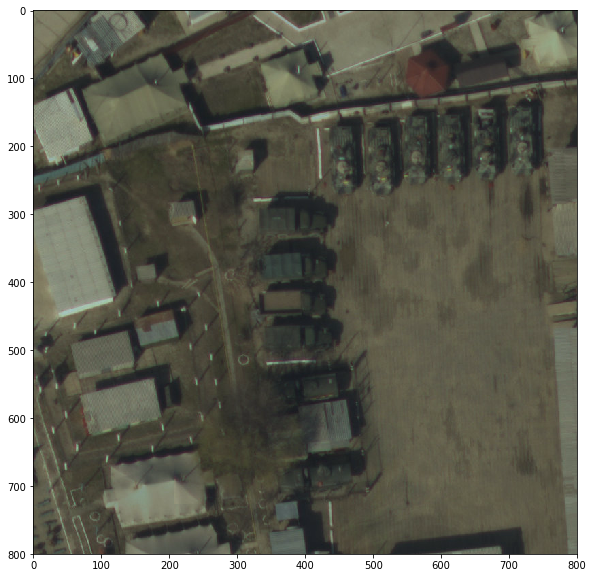

In [29]:
plt.figure(figsize= (10, 10))
plt.imshow(Image.fromarray(np.uint8(final_img)));

In [57]:
final_img = pl.get_patch(0, 0, 800, 800)

In [58]:
final_img.shape

(800, 800, 3)

In [75]:
cars_img = Image.open('/home/kruglov/projects/cit/grayA_cars_annotated.png')

In [76]:
cars_arr = np.array(cars_img)

In [77]:
cars_arr.shape

(8313, 7570, 2)

In [78]:
cars_arr[:,:,1].sum() / 255

22.0

In [82]:
mask = cars_arr[:,:,1] == 255

grid = np.mgrid[0:cars_arr.shape[0],0:cars_arr.shape[1]]

coords_list = grid[:,mask]
coords = coords_list[:,3]

In [84]:
coords_list.shape

(2, 22)

In [93]:
coords_list[:, np.random.choice(coords_list.shape[1], 50)].shape

(2, 50)

In [81]:
coords

array([3885, 5971])

In [51]:
scanline = band.ReadRaster( int(coords[1]-50), int(coords[0]-50), 100, 100, \
                             100, 100, gdal.GDT_Float32 )

In [52]:
tuple_of_floats = struct.unpack('f' * 100 * 100, scanline)

In [53]:
img = np.array(list(tuple_of_floats)).reshape(100, 100)

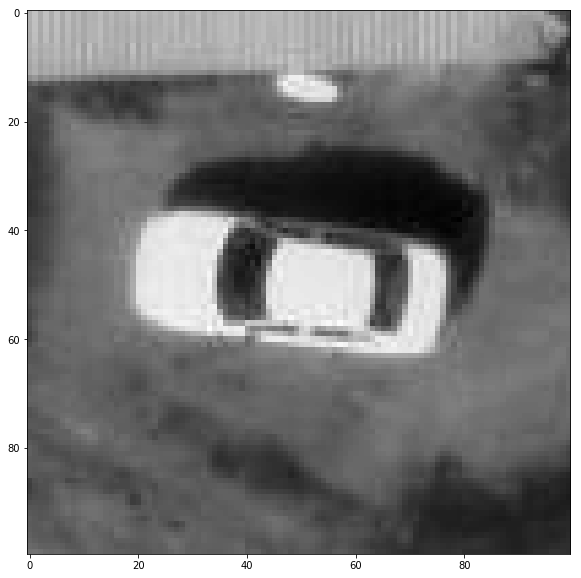

In [54]:
plt.figure(figsize= (10, 10))
plt.imshow(img, cmap= 'gray');

In [14]:
from math import ceil

In [15]:
import struct

In [46]:
class CITDataset(Dataset):
    
    def __init__(self, band, paths, transform= None):
        # parameters
        self.width = self.height = 224
        
        self.band = band
        print ('Тип данных: ',gdal.GetDataTypeName(self.band.DataType))
        print ('Размер: ', self.band.XSize, self.band.YSize)
        
        self.pos = self.get_coords(paths['pos'])
        self.neg = self.get_coords(paths['neg'])
        self.coords = self.pos
        self.transform = transform


    def __getitem__(self, index):
        coords = self.coords[:,index]
        width = self.width
        height = self.height
        scanline = self.band.ReadRaster(int(coords[1]-ceil(width / 2)), \
                                        int(coords[0]-ceil(height / 2)), \
                                        width, height, \
                                        width, height, gdal.GDT_Float32 )

        tuple_of_floats = struct.unpack('f' * width * height, scanline)
        img = np.array(list(tuple_of_floats)).reshape(height, width)
        img = np.expand_dims(img, 0)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img


    def __len__(self):
        return len(self.pos) + len(self.neg)
    
   
    def read_raster(self):
        scanline = self.band.ReadRaster( 2000, 2000, 1000, 1000, \
                             1000, 1000, gdal.GDT_Float32 )
    
    def get_coords(self, path):
        img = np.array(Image.open(path))
        mask = img[:,:,1] == 255
        grid = np.mgrid[0:img.shape[0],0:img.shape[1]]
        coords = grid[:,mask]
        
        return coords

In [47]:
paths = {
        'band':'/home/kruglov/projects/cit/grayA.tif',
        'pos': '/home/kruglov/projects/cit/grayA_cars_annotated.png',
        'neg': '/home/kruglov/projects/cit/grayA_neg_annotated.png'
}

In [48]:
ds = CITDataset(band, paths)

Тип данных:  Byte
Размер:  7570 8313


In [49]:
ds.band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fc280c0c150> >

In [50]:
ds.coords[:,0]

array([1527, 6938])

In [51]:
ds.band.XSize, ds.band.YSize

(7570, 8313)

In [52]:
ds.read_raster()

In [53]:
scanline = ds.band.ReadRaster( 2000, 2000, 1000, 1000, \
                             1000, 1000, gdal.GDT_Float32 )

In [54]:
inputs = ds.__getitem__(4)

In [55]:
inputs.shape

(1, 224, 224)

TypeError: Invalid dimensions for image data

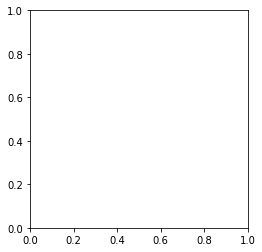

In [56]:
plt.imshow(inputs, cmap= 'gray');